# Understanding the ECCO Lat-Lon-Cap grid

**Overview**

In this notebook, we will look take a look at the ECCO Lat-Lon-Cap grid.

**Import Modules**

First, import the modules required to access data from netCDF files and create plots:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from matplotlib.gridspec import GridSpec

## Data for this notebook
In this notebook, we will use bathymetry and data from the Version 4 state estimate. 

Begin by identifying the location of your data folder here:

In [2]:
# Define a path to a data folder
data_folder = '../data'

To download the data, you can use the following links:
- Grid organized in tiles: [Version4/Release4/nctiles_grid/ECCO-GRID.nc](https://ecco.jpl.nasa.gov/drive/files/Version4/Release4/nctiles_grid/ECCO-GRID.nc)
- Bathymetry input binary: [Version4/Release4/input_init/bathy_eccollc_90x50_min2pts.bin](https://ecco.jpl.nasa.gov/drive/files/Version4/Release4/input_init/bathy_eccollc_90x50_min2pts.bin)

Note that the file paths in this notebook assume that the file structure on the ECCO drive is maintained on the local drive.

## ECCO Tiles
The ECCO Lat-Lon-Cap (LLC) grid can be thought of as a set of 13 - and it is often distributed this way. Let's take a look at some of the model fields:

In [3]:
# identify path to the march data file
grid_file = os.path.join(data_folder,'ECCO','Version4','Release4','nctiles_grid','ECCO-GRID.nc')
ds = xr.open_dataset(grid_file)
Depth = ds['Depth'][:,:]
ds.close()

Let's take a look at a plot of the depth organized in tiles:

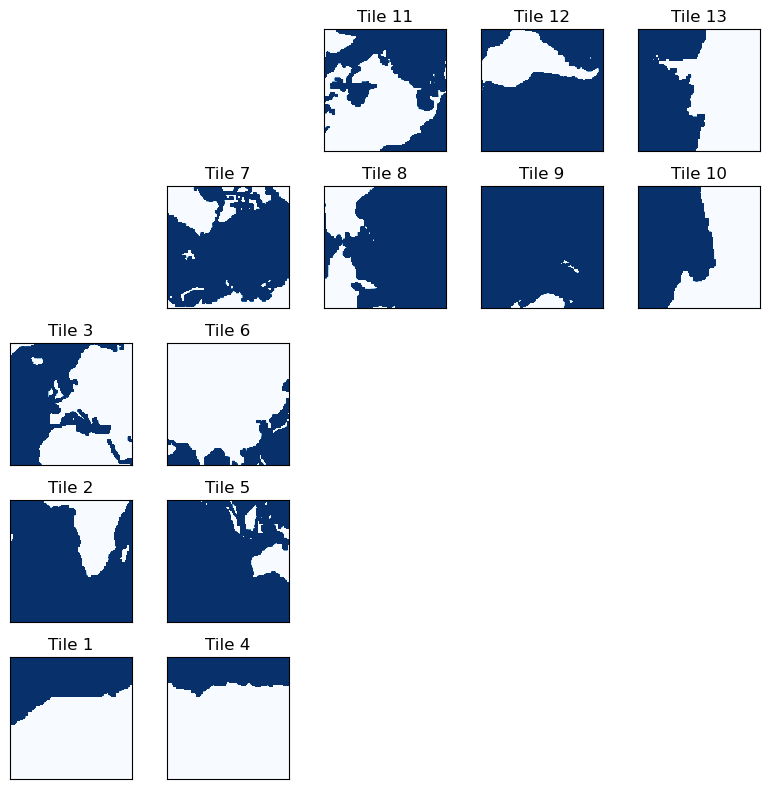

In [4]:
# quick dictionary to place tiles at different lcoations
tile_to_subplot = {1: [5, 1], 2: [4, 1], 3: [3, 1],
                       4: [5, 2], 5: [4, 2], 6: [3, 2],
                       7: [2, 2],
                       8: [2, 3], 9: [2, 4], 10: [2, 5],
                       11: [1, 3], 12: [1, 4], 13: [1, 5]}

fig = plt.figure(figsize=(8,8))

vmin=0
vmax=5

for tile_number in range(13):
    row = tile_to_subplot[tile_number+1][0]
    col = tile_to_subplot[tile_number+1][1]
    counter = (row - 1) * 5 + col

    plt.subplot(5, 5, counter)

    plt.imshow(Depth[tile_number, :, :], origin='lower', cmap='Blues',vmin=vmin,vmax=vmax)
    plt.title('Tile '+str(tile_number+1))

    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

plt.tight_layout()

As we can see, the tiles are grouped into sets of longitude bands. Tiles 1-3 cover the eastern Atlantic ocean, tiles 4-6 cover most of the Indian ocean, tile 7 corresponds to the Arctic (the "cap" of the lat-lon-cap grid), tiles 8-10 are the western Pacific, and tiles 11-13 are the remainder. 

There is an important observation to be made here about the orientation of the tiles: the tiles 8-10 and 11-13 are rotated *in the model* coordinates, not just in this plot. This means that vector quantities need to be treated with care. For example, the velocity vectors **UVEL and VVEL do not correspond to zonal and meridional velocity**. These quantities are defined directionally depending on the orientation of the grid. For example, on tile 2, a vector quantity with positive `UVEL` and zero `VVEL` may point in roughly a zonal direction. However, on tile 9, a vector quantity with positive `UVEL` and zero `VVEL` will be pointing in roughly a negative meridional direction (i.e. southward)! To assess vector quantities in zonal and meridional directions, use the cosine and sine of the grid (provided in the ECCO grid files) to construct a rotation matrix.

## ECCO Faces

The ECCO state estimate output fields are often provided in 13 tiles of equal size but, in reality, the grid is composed of 5 faces which we can recreate as follows:

In [5]:
face_1 = np.vstack([Depth[0,:,:], Depth[1,:,:], Depth[2,:,:]])
face_2 = np.vstack([Depth[3,:,:], Depth[4,:,:], Depth[5,:,:]])
face_3 = Depth[6,:,:]
face_4 = np.hstack([Depth[7,:,:], Depth[8,:,:], Depth[9,:,:]])
face_5 = np.hstack([Depth[10,:,:], Depth[11,:,:], Depth[12,:,:]])

And visualize as follows:

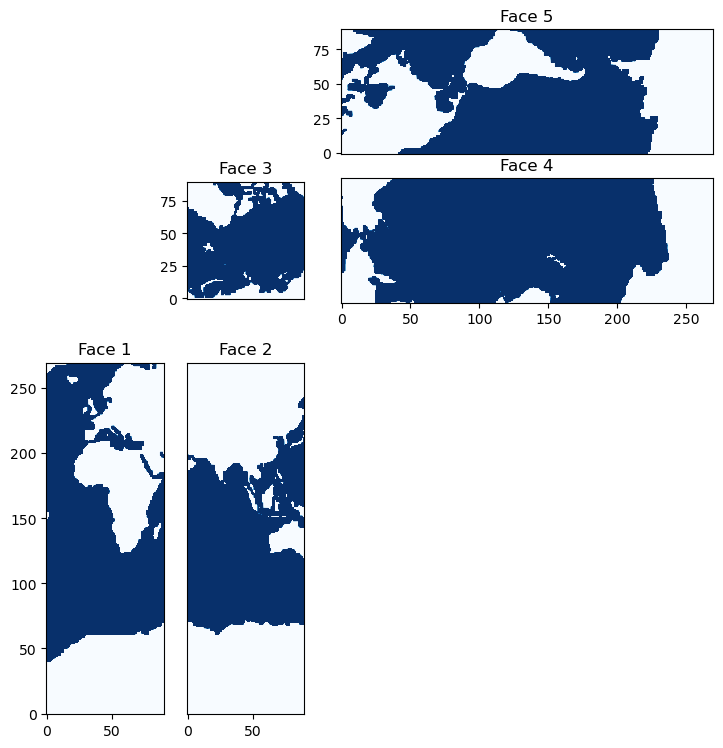

In [6]:
fig = plt.figure(figsize=(8,8))
gs = GridSpec(5,5,  left=0.05, right=0.90, bottom=0.05, top=0.95)

ax1 = fig.add_subplot(gs[2:, 0])
ax1.imshow(face_1, origin='lower', cmap='Blues',vmin=vmin,vmax=vmax)
ax1.set_title('Face 1')

ax2 = fig.add_subplot(gs[2:, 1])
ax2.imshow(face_2, origin='lower', cmap='Blues',vmin=vmin,vmax=vmax)
ax2.set_title('Face 2')
ax2.set_yticks([])

ax3 = fig.add_subplot(gs[1, 1])
ax3.imshow(face_3, origin='lower', cmap='Blues',vmin=vmin,vmax=vmax)
ax3.set_title('Face 3')
ax3.set_xticks([])

ax4 = fig.add_subplot(gs[1, 2:])
ax4.imshow(face_4, origin='lower', cmap='Blues',vmin=vmin,vmax=vmax)
ax4.set_title('Face 4')
ax4.set_yticks([])

ax5 = fig.add_subplot(gs[0, 2:])
ax5.imshow(face_5, origin='lower', cmap='Blues',vmin=vmin,vmax=vmax)
ax5.set_title('Face 5')
ax5.set_xticks([])
plt.show()

This grid was designed to avoid "singularities" in the model grid that occur in the ocean - locations where grid lines naturally converge. For example, if the model was set up on a simple lon-lat grid, then the gridlines would converge at the pole. In this case, the grid size would be very small, necessitating a very small timestep on account of the CFL condition. In this layout, all areas where gridlines converge - the corners of the faces - are placed on land. These corners are located on the Greenland, Siberian, North American, and Antarctic land masses.

### Grid Naming Convention and Resolution

The grids for the version 4 and 5 state estimates are termed the LLC90 and LLC270 grids for how many points span each face. For example, in the plot above, we see that each face spans 90 grid points. This also gives us a sense for the nominal resolution of the grid. The LLC90 has a nominal resolution of about 1 degree (360 degrees of longitude divided by 4 faces with 90 points each). Similarly, the LLC270 has a nominal resolution of about 1/3 degree. Other LLC grids have been constructd simlarly for LLC50, LLC1080, LLC2160, and LLC4320 grid.

## ECCO Compact Form

When reading or writing from binaries used in the models underlying the state estimates, it's useful to understand the format of the file organization - the "compact" form. This organization is straight-forward with notion of the faces introduced above. Let's take a look at how a compact-form bathymetry file is formatted:

In [7]:
bathy_file = os.path.join(data_folder,'ECCO','Version4','Release4',
                          'input_init','bathy_eccollc_90x50_min2pts.bin')
bathy = np.fromfile(bathy_file, '>f4')

# read in face 1
face_1_points = 90*270
face_1_bathy = bathy[:face_1_points].reshape((270,90))

# read in face 2
face_2_points = 90*270
face_2_bathy = bathy[face_1_points:face_1_points+face_2_points].reshape((270,90))

# read in face 3
face_3_points = 90*90
face_3_bathy = bathy[face_1_points+face_2_points:face_1_points+face_2_points+face_3_points].reshape((90,90))

# read in face 4
face_4_points = 270*90
face_4_bathy = bathy[face_1_points+face_2_points+face_3_points:
                     face_1_points+face_2_points+face_3_points+face_4_points].reshape((90,270))

# read in face 5
face_5_bathy = bathy[face_1_points+face_2_points+face_3_points+face_4_points:].reshape((90,270))

We can plot these faces to see that they match those constucted from the tiles above:

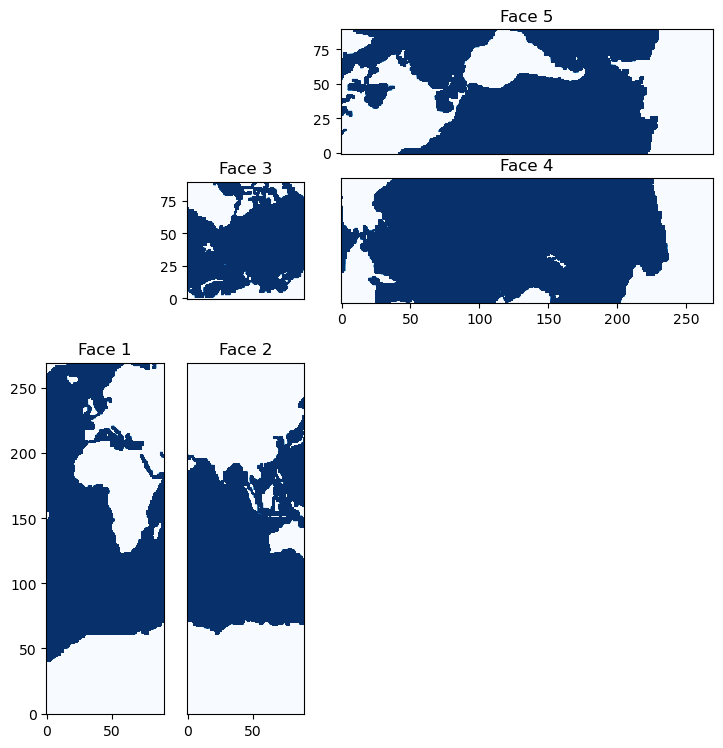

In [8]:
fig = plt.figure(figsize=(8,8))
gs = GridSpec(5,5,  left=0.05, right=0.90, bottom=0.05, top=0.95)

vmin=-5
vmax=0

ax1 = fig.add_subplot(gs[2:, 0])
ax1.imshow(face_1_bathy, origin='lower', cmap='Blues_r',vmin=vmin,vmax=vmax)
ax1.set_title('Face 1')

ax2 = fig.add_subplot(gs[2:, 1])
ax2.imshow(face_2_bathy, origin='lower', cmap='Blues_r',vmin=vmin,vmax=vmax)
ax2.set_title('Face 2')
ax2.set_yticks([])

ax3 = fig.add_subplot(gs[1, 1])
ax3.imshow(face_3_bathy, origin='lower', cmap='Blues_r',vmin=vmin,vmax=vmax)
ax3.set_title('Face 3')
ax3.set_xticks([])

ax4 = fig.add_subplot(gs[1, 2:])
ax4.imshow(face_4_bathy, origin='lower', cmap='Blues_r',vmin=vmin,vmax=vmax)
ax4.set_title('Face 4')
ax4.set_yticks([])

ax5 = fig.add_subplot(gs[0, 2:])
ax5.imshow(face_5_bathy, origin='lower', cmap='Blues_r',vmin=vmin,vmax=vmax)
ax5.set_title('Face 5')
ax5.set_xticks([])

plt.show()

Hopefully this notebook has helped demystify some of the peculiarities of the ECCO grid.